In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


In [2]:
def get_data(tickers, start_date, end_date, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']):
    """
    Obs:
    The function gets the Adjusted Close price for the tickers within the dates informed
    
    Input: 
    
    tickers: list of tickers to get
    start_data: data format like "aaaa-mm-dd". Necessary use a valid trade day
    end_data: data format like "aaaa-mm-dd". Necessary use a valid trade day
    columns: desired columns to get from yfinance (Open, High, Low, Close, Volume)

    Output:
    dataframe with the adjusted close price for the tickers and dates informed. 
    
    """
    
    #
    
        
    df = yf.download(tickers, start=start_date, end=end_date)[columns]
   
    return df



def norm(df, start, end):
    df = df.loc[start:end]
    norm_df = df / df.iloc[0,:]
    return norm_df




def rolling_mean(df, window):
    """
    Obs:
    The function gets the simple moving average for each ticker
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers

    Output:
    dataframe the simple moving average for each ticker
    
    """    
    sma = df.rolling(window=window).mean()
    return sma 



def rolling_std(df, window):
    """
    Obs:
    The function gets the simple moving average for each ticker
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers
    window: number of days to compose the interval

    Output:
    dataframe the simple moving average for each ticker
    
    """    
    moving_std = df.rolling(window=window).std()
    return moving_std



def bollinger_bands(df, window, number_of_std):
    
    """
    Obs:
    The function returns the Bollinger Bands based on df, ticker, window and number of standard deviation
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers
    window: number of days to compose the interval
    number_of_std: number of the std for calculate the bollinger bands

    Output:
    sma : simple moving average
    upper_band
    lower_band
    
    """  
    sma = rolling_mean(df, window)
    moving_std = rolling_std(df, window)
    upper_band = sma + moving_std * number_of_std
    lower_band = sma - moving_std * number_of_std
    return sma, upper_band, lower_band



def daily_return(df, periods_to_shift):
    
    """
    Obs:
    The function returns the stock's returns based on the period informed
    
    Input: 
    
    df: dataframe with stock prices
    periods_to_shift: Periods to shift for forming percent change.
    
    Output:
    dataframe with returns based on the period informed
    
    """  
    
    df = df.pct_change(periods = periods_to_shift)
    # check the type of object to do the correct change in the first row 
    if isinstance(df, pd.Series) != True:
        df.iloc[0,:] = 0
    else:
        df[0] = 0
    return df




# ============================================= Plot Functions =================================

def plot_data(df, title, x_label, y_label):
    df.plot(figsize=(15,8))  
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.axhline(y=1)
    plt.show()



def plot_line(stock):
    """
    Only for individual stocks
    """
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    
    plt.figure(figsize=(15,8))
    plt.plot(stock, label=stock.name)
    # plot horizontal lines
    plt.axhline(y = 0, color = 'black')
    plt.axhline(y = stock.std(), color = 'orange', linestyle= 'dashed', label='1 std')
    plt.axhline(y = -stock.std(), color = 'orange', linestyle='dashed')
    plt.axhline(y = stock.std() * 2, color = 'r', linestyle= 'dashed', label='2 std')
    plt.axhline(y = -stock.std() * 2, color = 'r', linestyle='dashed')   
    plt.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.title('Historical Return')
    plt.show()

def plot_hist(d_return):
    d_return.hist(figsize=(15,8), bins=100)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    plt.axvline(d_return.mean(), color='w', linestyle='dashed', label='mean')
    plt.axvline(d_return.std(), color='orange', linestyle='dashed', label='1 std')
    plt.axvline(-d_return.std(), color='orange', linestyle='dashed')
    plt.axvline(d_return.std() * 2, color='r', linestyle='dashed', label='2 std')
    plt.axvline(-d_return.std() * 2, color='r', linestyle='dashed')            
    plt.legend(loc='upper right')
    print(f'The Kurtosis is: {d_return.kurtosis()}') # bigger than 0 = Fat Tails    
    
    
def hist_seaborn(d_return):
    sns.set(font_scale=2)
    sns.displot(d_return, kde=True, height=10, aspect=2)
    plt.axvline(d_return.mean(), color='w', linestyle='dashed', label='mean')
    plt.axvline(d_return.std(), color='orange', linestyle='dashed', label='1 std')
    plt.axvline(-d_return.std(), color='orange', linestyle='dashed')
    plt.axvline(d_return.std() * 2, color='r', linestyle='dashed', label='2 std')
    plt.axvline(-d_return.std() * 2, color='r', linestyle='dashed')            
    plt.legend(loc=1, fontsize='20')
    plt.title(f'{d_return.name} Daily Return Distribution')
    print(f'The Kurtosis is: {d_return.kurtosis()}') # bigger than 0 = Fat Tails    

def scatter_searborn(df, x_data, y_data):
    sns.lmplot(data=df, x=x_data, y=y_data,
              height=8, aspect=1.5) #height=6, width=1.5 times larger than height 
    
    sns.scatterplot(data=df, x= x_data, y= y_data, s=100)
    beta_y, alpha_y = np.polyfit(d_return[x_data], d_return[y_data], 1)
    plt.plot(d_return[x_data], beta_y * d_return[x_data] + alpha_y, '-', color='r')
    plt.title(f'Relation Between {x_data} and {y_data} Daily Return ')
    print(f'Beta Coeficient between {x_data} and {y_data} is {beta_y}')
    print(f'Alpha Coeficient between {x_data} and {y_data} is {alpha_y}')


# Get Data

In [3]:
""" 

AAPL - Technology: Consumer Electronics
MSFT - Technology: Software Infrastructure
GOOGL - Communication Services: Internet Content
DIS - Communication Services: Entertainment
AMZN - Consumer Cyclical: Internet Retail
TSLA - Consumer Cyclical: Auto Manufacturers
PG - Consumer Defensive: Household & Personal Products
KO - Consumer Defensive: Beverages - Non Alcoholic
JPM - Financial: Banks
MS - Financial: Capital Markets
JNJ - Healthcare: Drug Manufacturers
UNH - Healthcare: Healthcare Plans
XOM - Energy: Oil & Gas
CVX - Energy: Oil & Gas
AMT - Real State: Reit Specialty
PLD - Real State: Reit Industrial
HON - Industrials: Specialty Industrial Machinery
RTX - Industrials: Aerospace & Defense
NEE - Utilities: regulated Electric
LIN - Basic Materials: Speiclaty Chemicals

"""    

stocks = get_data(['SPY','AAPL', 'MSFT','GOOG','DIS', 'AMZN', 'TSLA', 'PG', 'KO','JPM','MS','JNJ','UNH','XOM','CVX', 'AMT', 'PLD','HON','RTX','NEE','LIN'], '2017-01-01', '2022-10-30','Adj Close')

[*********************100%***********************]  21 of 21 completed


# Take a look at data

In [4]:
stocks.head(5)

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,27.174751,94.504707,37.683498,91.029167,101.584358,39.306999,98.629608,98.923882,73.776642,34.493885,...,36.772434,57.645382,25.823841,71.254478,45.118950,60.436787,202.856491,14.466000,147.823471,67.322083
2017-01-04,27.144339,94.673843,37.859001,91.005974,102.886726,39.345001,98.901268,98.761642,73.912720,34.370102,...,37.259319,57.387451,25.899975,71.508347,45.922207,60.474949,204.063339,15.132667,148.244690,66.581383
2017-01-05,27.282375,94.344421,39.022499,90.612068,102.829262,39.701000,99.121994,99.794937,73.232361,34.452618,...,36.917652,57.387451,25.884754,71.982269,45.939289,60.720345,203.901230,15.116667,148.491837,65.588852
2017-01-06,27.586536,93.721230,39.799500,90.249016,104.361465,40.307499,100.624626,99.316719,73.240875,34.444370,...,37.455788,57.884869,25.808620,71.956894,46.238380,61.374695,204.630753,15.267333,148.702469,65.551811
2017-01-09,27.839207,93.498672,39.846001,89.476624,103.767723,40.332500,99.792664,99.299622,73.291901,34.097778,...,36.482025,57.700642,25.743357,71.423752,45.888023,60.802135,203.955322,15.418667,148.281265,64.470398


In [5]:
#Check the Dtype for each column
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1467 entries, 2017-01-03 to 2022-10-28
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1467 non-null   float64
 1   AMT     1467 non-null   float64
 2   AMZN    1467 non-null   float64
 3   CVX     1467 non-null   float64
 4   DIS     1467 non-null   float64
 5   GOOG    1467 non-null   float64
 6   HON     1467 non-null   float64
 7   JNJ     1467 non-null   float64
 8   JPM     1467 non-null   float64
 9   KO      1467 non-null   float64
 10  LIN     1467 non-null   float64
 11  MS      1467 non-null   float64
 12  MSFT    1467 non-null   float64
 13  NEE     1467 non-null   float64
 14  PG      1467 non-null   float64
 15  PLD     1467 non-null   float64
 16  RTX     1467 non-null   float64
 17  SPY     1467 non-null   float64
 18  TSLA    1467 non-null   float64
 19  UNH     1467 non-null   float64
 20  XOM     1467 non-null   float64
dtypes: float64(21)
memo

In [6]:
# descriptive analysis of adjusted close price
stocks.describe()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
count,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,...,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000
mean,85.004443,192.767641,108.433714,101.309654,126.721950,78.924160,158.851350,135.454320,108.313167,46.310471,...,56.021455,167.594642,55.501574,107.734867,85.799044,74.397589,311.173818,111.602412,299.008952,59.913561
std,48.095908,55.591202,42.550774,23.681651,27.968534,32.567355,34.809923,21.657080,25.132409,8.025301,...,21.313522,83.112447,19.103723,28.096784,32.235317,11.367707,76.831901,116.342831,111.106240,14.680127
min,27.144339,91.709152,37.683498,47.611778,85.760002,39.306999,98.294144,95.439667,70.266006,33.371590,...,25.639854,57.387451,25.743357,62.960373,41.393215,43.952831,202.856491,11.931333,144.316681,26.768913
25%,41.997887,132.135223,79.645000,86.605541,104.594795,53.981750,129.913216,117.834068,91.400223,39.288359,...,39.600546,95.280506,36.999424,78.673771,57.674461,66.077835,249.904739,20.473667,219.632896,54.666576
50%,63.539436,205.956451,95.471001,97.420341,114.609474,63.172501,154.719376,129.224884,100.096954,45.498219,...,45.541145,145.303787,54.390919,110.789101,80.597527,73.587654,282.661743,25.063334,254.718216,60.605766
75%,132.123680,239.437256,155.036247,104.097771,142.702507,105.849751,190.624641,157.277901,124.984634,51.949823,...,76.740280,242.230385,72.764008,131.714874,107.712650,83.397690,380.934021,225.028328,390.707184,63.957256
max,180.959747,295.193634,186.570496,178.598465,201.910004,150.709000,228.017639,182.411407,166.523987,64.799698,...,105.765915,339.924835,91.410133,161.211899,169.552902,103.137680,470.083679,409.970001,549.545959,109.815956


In [7]:
# higher prices
stocks.describe().loc['max'][:3]

AAPL    180.959747
AMT     295.193634
AMZN    186.570496
Name: max, dtype: float64

In [8]:
# lower prices
stocks.describe().loc['min'][:3]

AAPL    27.144339
AMT     91.709152
AMZN    37.683498
Name: min, dtype: float64

In [9]:
# Evaluating if there is null values in the data
stocks.isnull().sum()

AAPL    0
AMT     0
AMZN    0
CVX     0
DIS     0
GOOG    0
HON     0
JNJ     0
JPM     0
KO      0
LIN     0
MS      0
MSFT    0
NEE     0
PG      0
PLD     0
RTX     0
SPY     0
TSLA    0
UNH     0
XOM     0
dtype: int64

# Fill Nan

In [10]:
# Dealing with missing data.
stocks.fillna(method='ffill', inplace=True)
stocks.fillna(method='bfill', inplace=True) # growth companies in general are newer compared to value companies and will need this method 

In [11]:
# Evaluating if there is null values in the data
stocks.isnull().sum()

AAPL    0
AMT     0
AMZN    0
CVX     0
DIS     0
GOOG    0
HON     0
JNJ     0
JPM     0
KO      0
LIN     0
MS      0
MSFT    0
NEE     0
PG      0
PLD     0
RTX     0
SPY     0
TSLA    0
UNH     0
XOM     0
dtype: int64

# Cumulative Return

In [12]:
# Cumulative return between start date and end date
norm_df = norm(stocks, '2008-01-02','2018-01-02')
norm_df.head()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-01-04,0.998881,1.001790,1.004657,0.999745,1.012821,1.000967,1.002754,0.998360,1.001844,0.996411,...,1.013240,0.995526,1.002948,1.003563,1.017803,1.000631,1.005949,1.046085,1.002849,0.988998
2017-01-05,1.003960,0.998304,1.035533,0.995418,1.012255,1.010024,1.004992,1.008805,0.992623,0.998804,...,1.003949,0.995526,1.002359,1.010214,1.018182,1.004692,1.005150,1.044979,1.004521,0.974255
2017-01-06,1.015153,0.991710,1.056152,0.991430,1.027338,1.025453,1.020227,1.003971,0.992738,0.998565,...,1.018583,1.004154,0.999411,1.009858,1.024811,1.015519,1.008746,1.055394,1.005946,0.973704
2017-01-09,1.024451,0.989355,1.057386,0.982945,1.021493,1.026090,1.011792,1.003798,0.993430,0.988517,...,0.992103,1.000959,0.996883,1.002376,1.017045,1.006045,1.005417,1.065856,1.003097,0.957641


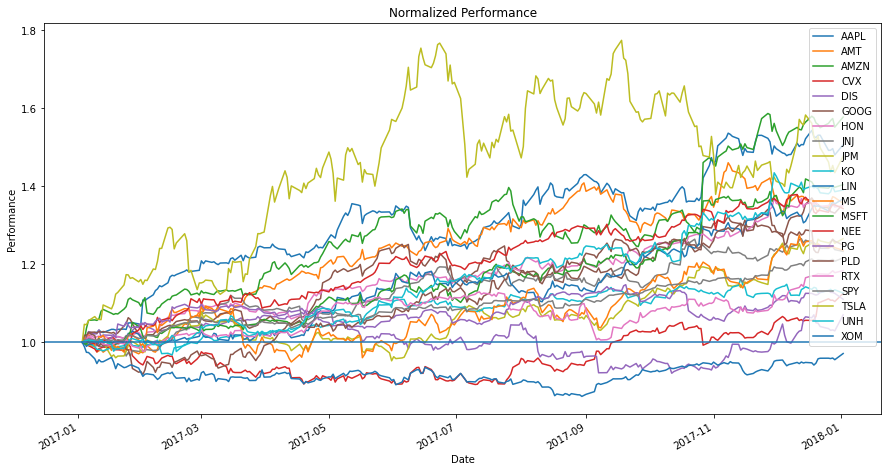

In [13]:
# Normalized cumulative return
plot_data(norm_df, 'Normalized Performance', 'Date', 'Performance')

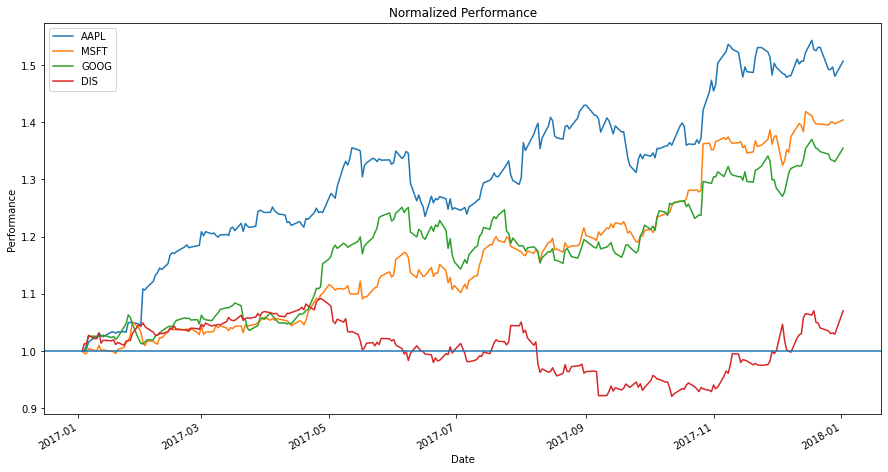

In [14]:
# Tech and Communication Companies
plot_data(norm_df[['AAPL', 'MSFT', 'GOOG','DIS']],'Normalized Performance', 'Date', 'Performance')

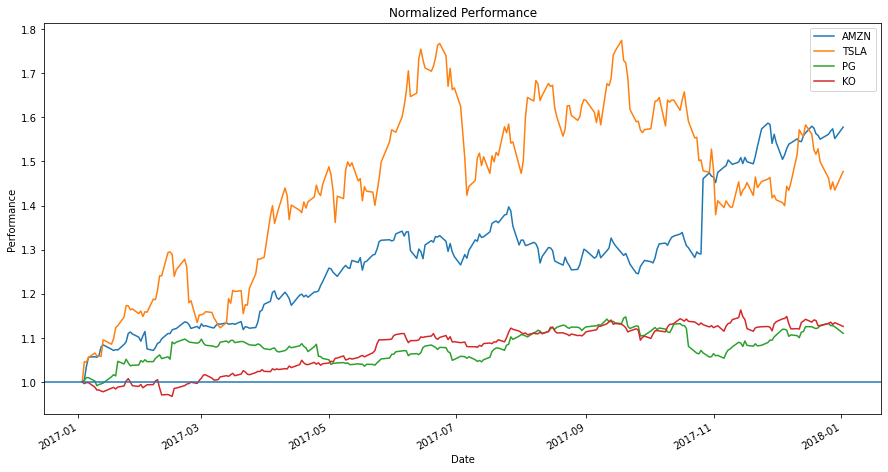

In [15]:
# Consumer Cyclical and Defensive Companies
plot_data(norm_df[['AMZN','TSLA','PG','KO']],'Normalized Performance', 'Date', 'Performance')

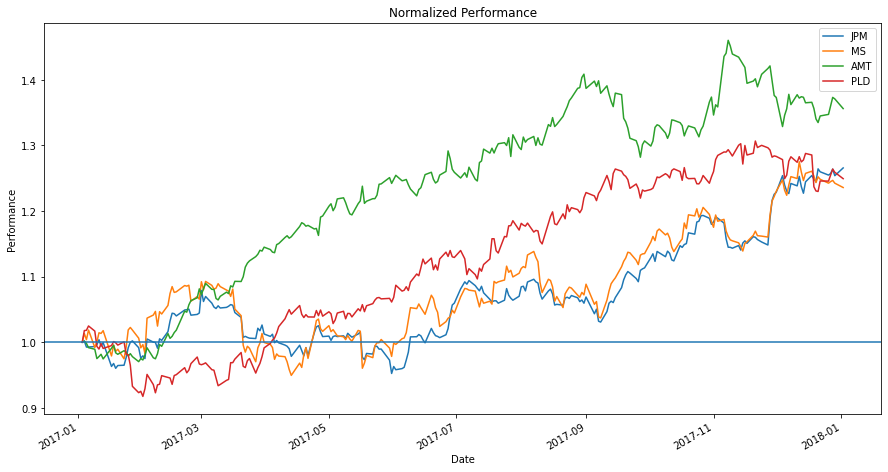

In [16]:
# Financial and Real State Companies
plot_data(norm_df[['JPM', 'MS', 'AMT','PLD']],'Normalized Performance', 'Date', 'Performance')

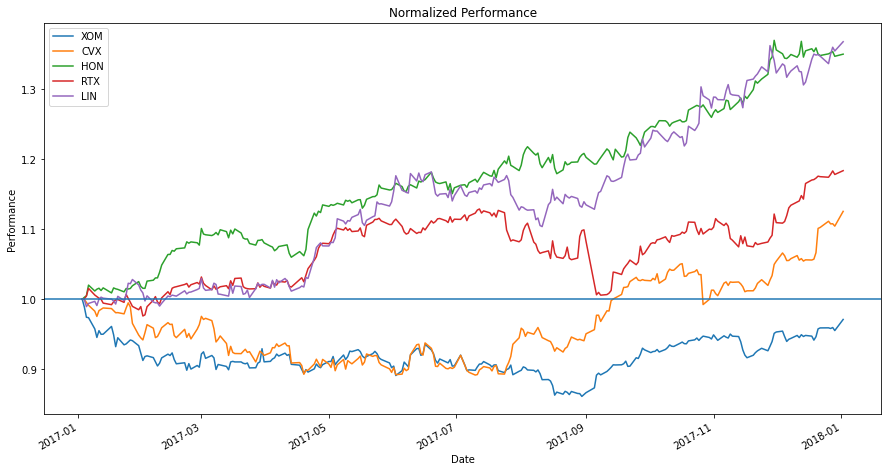

In [17]:
# Energy, Industrials and Basic Materials Companies
plot_data(norm_df[['XOM','CVX','HON','RTX', 'LIN']],'Normalized Performance', 'Date', 'Performance')

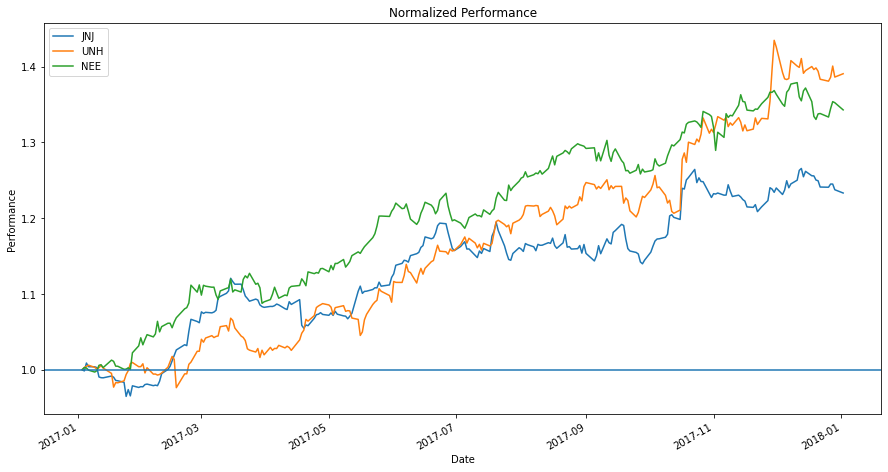

In [18]:
# Healthcare and Utilities Companies
plot_data(norm_df[['JNJ','UNH','NEE']],'Normalized Performance', 'Date', 'Performance')

# Daily Return

In [19]:
d_return = daily_return(stocks, 1)
d_return.head()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,-0.001119,0.001790,0.004657,-0.000255,0.012821,0.000967,0.002754,-0.001640,0.001844,-0.003589,...,0.013240,-0.004474,0.002948,0.003563,0.017803,0.000631,0.005949,0.046085,0.002849,-0.011002
2017-01-05,0.005085,-0.003480,0.030732,-0.004328,-0.000559,0.009048,0.002232,0.010463,-0.009205,0.002401,...,-0.009170,0.000000,-0.000588,0.006628,0.000372,0.004058,-0.000794,-0.001057,0.001667,-0.014907
2017-01-06,0.011149,-0.006605,0.019912,-0.004007,0.014900,0.015277,0.015159,-0.004792,0.000116,-0.000239,...,0.014577,0.008668,-0.002941,-0.000353,0.006511,0.010776,0.003578,0.009967,0.001418,-0.000565
2017-01-09,0.009159,-0.002375,0.001168,-0.008558,-0.005689,0.000620,-0.008268,-0.000172,0.000697,-0.010062,...,-0.025998,-0.003183,-0.002529,-0.007409,-0.007577,-0.009329,-0.003301,0.009912,-0.002833,-0.016497


In [20]:
d_return.describe()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
count,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,...,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000
mean,0.001382,0.000669,0.000908,0.000680,0.000203,0.000779,0.000623,0.000462,0.000546,0.000462,...,0.000773,0.001123,0.000885,0.000520,0.000777,0.000494,0.000519,0.002622,0.001050,0.000529
std,0.019618,0.016835,0.020958,0.020909,0.018738,0.018217,0.015991,0.012446,0.019061,0.012691,...,0.021242,0.018087,0.015853,0.012953,0.017553,0.019426,0.012444,0.038514,0.017589,0.019768
min,-0.128647,-0.151638,-0.140494,-0.221248,-0.129846,-0.111008,-0.120868,-0.100379,-0.149649,-0.096725,...,-0.156000,-0.147390,-0.134170,-0.087374,-0.172706,-0.144765,-0.109424,-0.210628,-0.172769,-0.122248
25%,-0.007433,-0.007025,-0.008536,-0.007640,-0.008149,-0.006586,-0.005844,-0.004889,-0.007953,-0.004565,...,-0.009253,-0.006577,-0.005837,-0.004864,-0.007296,-0.007110,-0.003633,-0.016371,-0.006796,-0.008823
50%,0.001097,0.001084,0.001360,0.000738,-0.000075,0.001317,0.000955,0.000393,0.000000,0.000800,...,0.000592,0.001149,0.001362,0.000736,0.001420,0.000664,0.000718,0.001663,0.001082,0.000250
75%,0.011418,0.008548,0.011066,0.009114,0.008021,0.009317,0.008002,0.006183,0.009255,0.006095,...,0.011333,0.010195,0.007657,0.006584,0.009424,0.008038,0.006100,0.019885,0.008575,0.009508
max,0.119808,0.122219,0.135359,0.227407,0.144123,0.104485,0.150684,0.079977,0.180125,0.064796,...,0.197700,0.142169,0.136904,0.120090,0.118103,0.157572,0.090603,0.198949,0.127989,0.126868


In [21]:
stds = d_return.describe().loc['std']
stds.sort_values(ascending=False)

TSLA    0.038514
MS      0.021242
AMZN    0.020958
CVX     0.020909
XOM     0.019768
AAPL    0.019618
RTX     0.019426
JPM     0.019061
DIS     0.018738
GOOG    0.018217
MSFT    0.018087
UNH     0.017589
PLD     0.017553
AMT     0.016835
LIN     0.016188
HON     0.015991
NEE     0.015853
PG      0.012953
KO      0.012691
JNJ     0.012446
SPY     0.012444
Name: std, dtype: float64

## Daily return behaviour

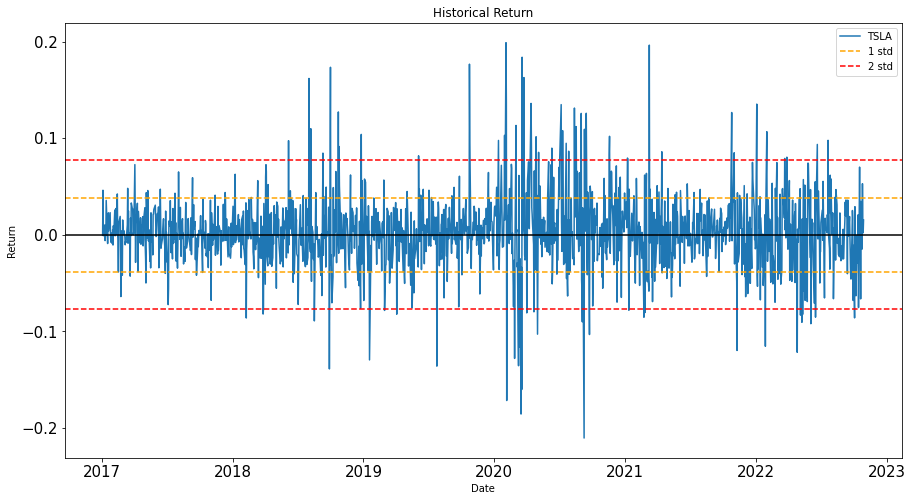

In [22]:
plot_line(d_return['TSLA'])

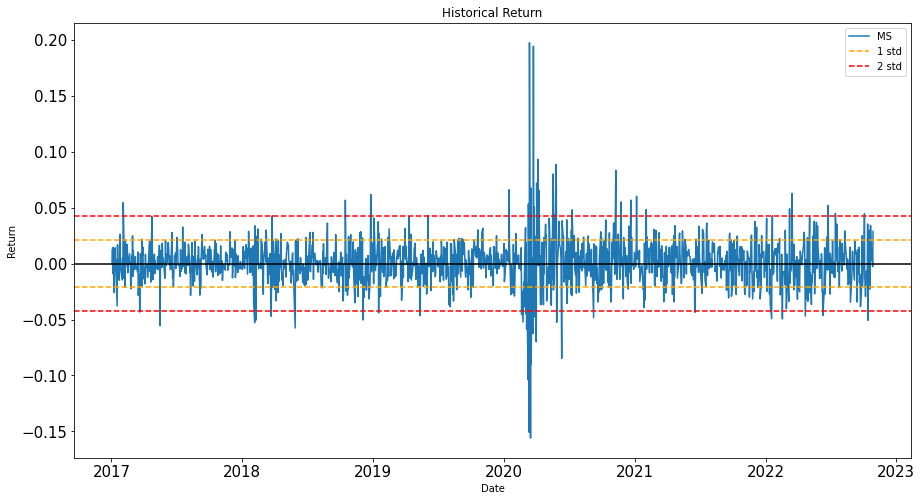

In [23]:
plot_line(d_return['MS'])

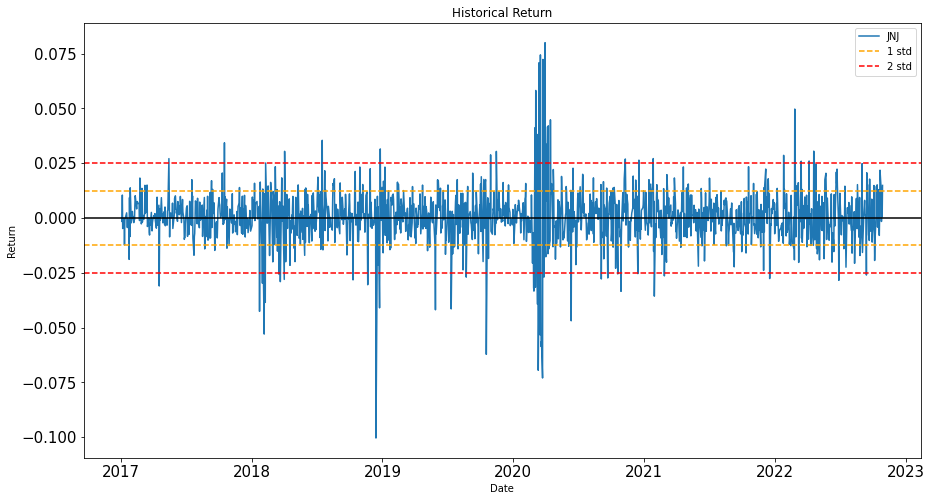

In [24]:
plot_line(d_return['JNJ'])

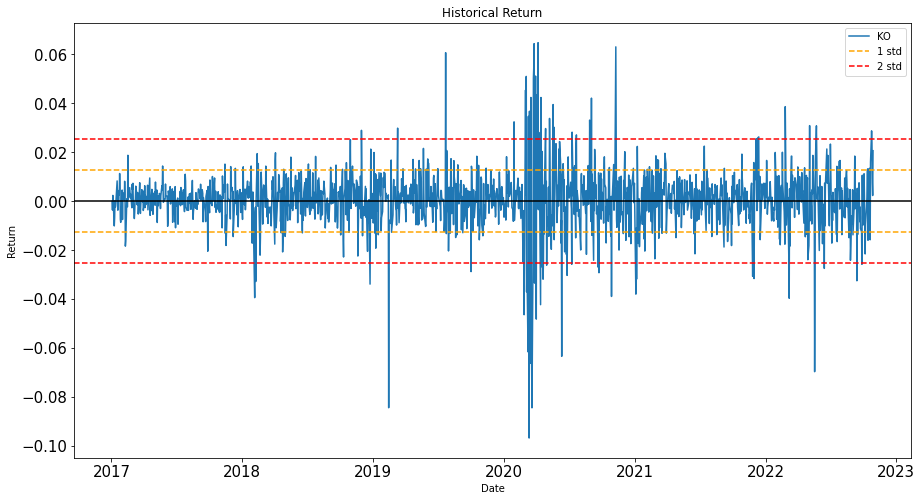

In [25]:
plot_line(d_return['KO'])

## Daily return behaviour - Histogram

The Kurtosis is: 5.341549000289977


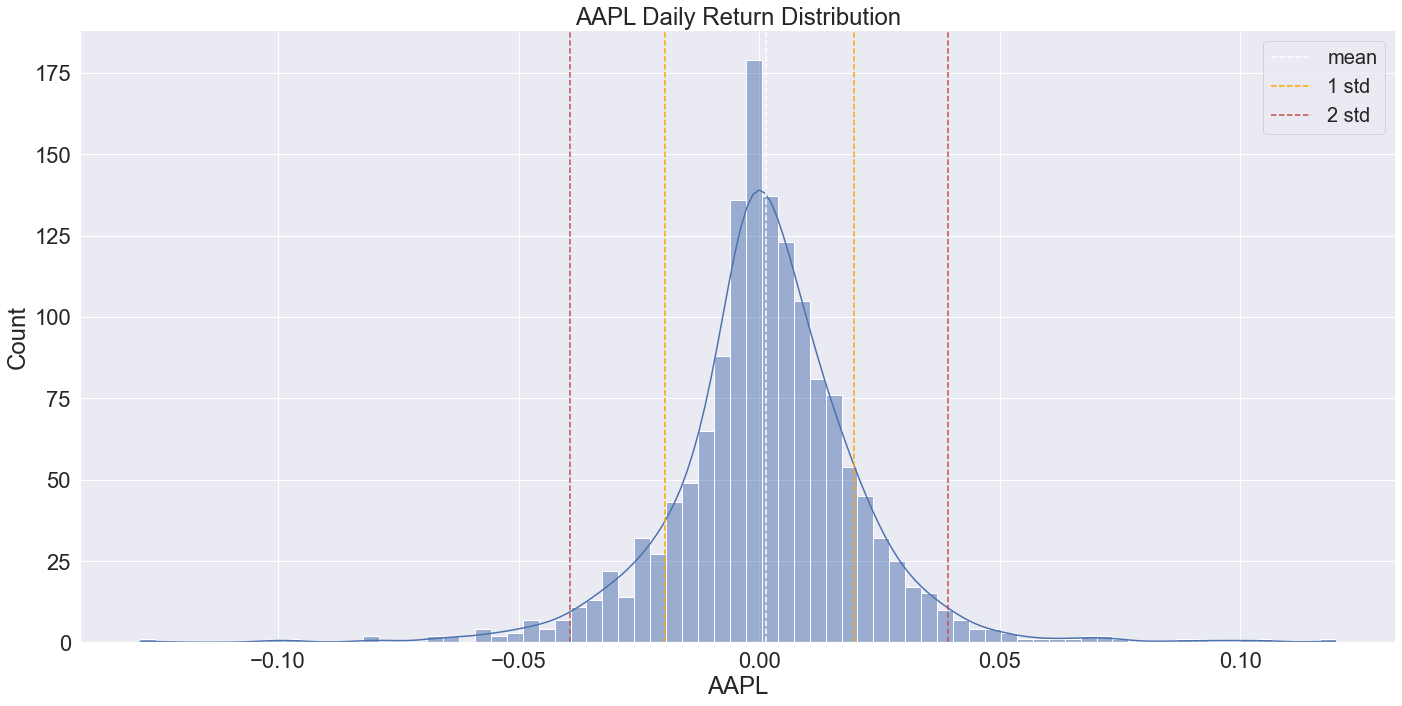

In [26]:
hist_seaborn(d_return['AAPL'])

# Scatter Plots

Beta Coeficient between SPY and JPM is 1.141085808053823
Alpha Coeficient between SPY and JPM is -4.5421838137925834e-05


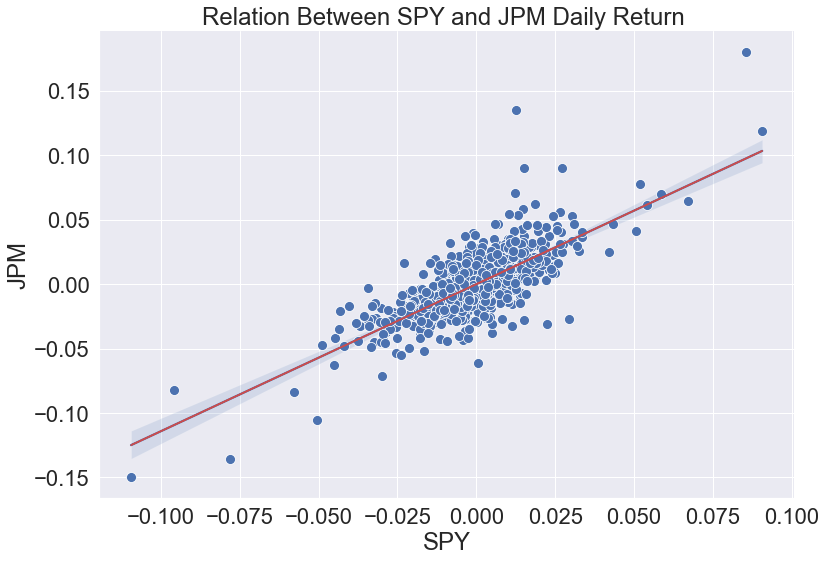

In [27]:
scatter_searborn(d_return, 'SPY', 'JPM')

Beta Coeficient between SPY and JNJ is 0.5804723688863328
Alpha Coeficient between SPY and JNJ is 0.00016059712369794466


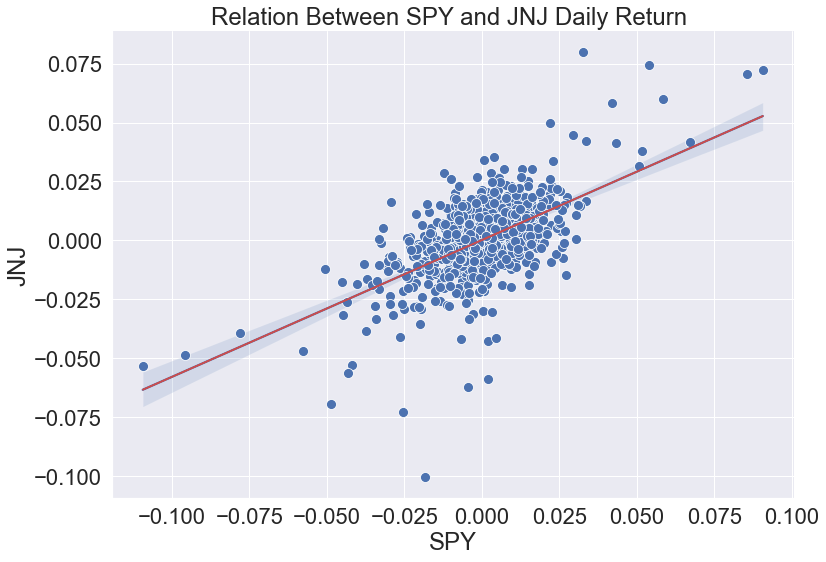

In [28]:
scatter_searborn(d_return, 'SPY', 'JNJ')

# Correlation

In [29]:
d_return_corr = d_return.corr(method='pearson')

<AxesSubplot:>

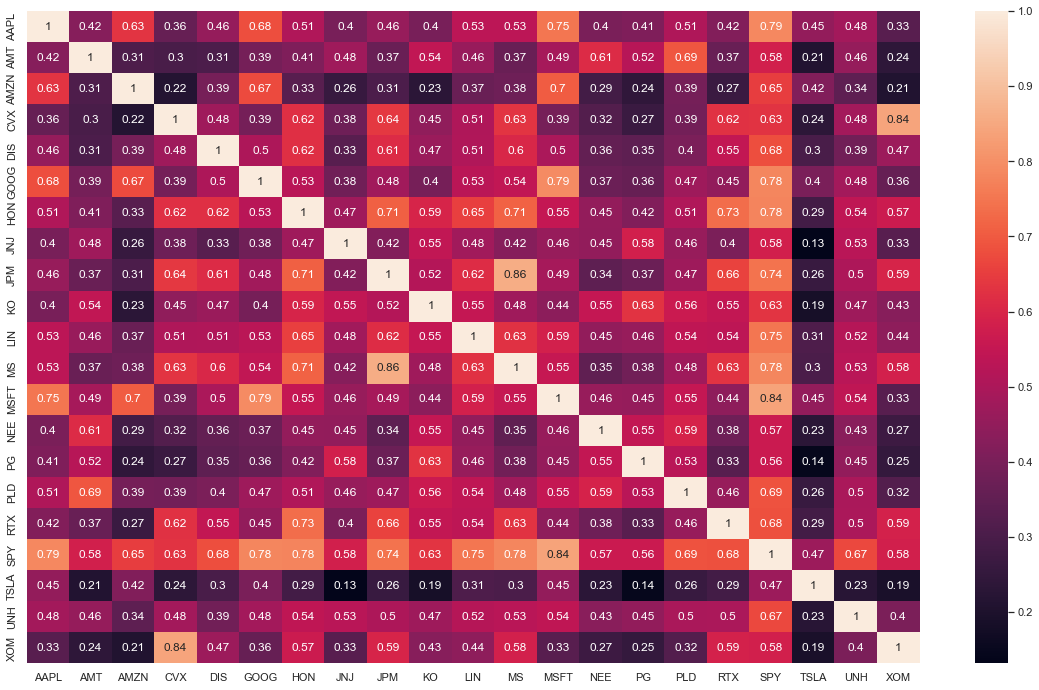

In [30]:
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(d_return_corr, annot=True)

# Technical Analysis

In [31]:
stocks['AAPL'].name

'AAPL'

In [32]:
def SMA_plot(df, n1, n2, n3):
    sma200 = rolling_mean(df, n1)
    sma50 = rolling_mean(df, n2)
    sma10 = rolling_mean(df, n3)
    print(len(df))
    print(len(sma200))
    
    list_sma200 = sma200.values.tolist()
    list_sma50 = sma50.values.tolist()
    list_sma10 = sma10.values.tolist()
    close = df.values.tolist()
    dates = df.index.values
    print(len(list_sma200))
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    plt.plot(dates, list_sma200, color='red', linestyle='dashed')
    plt.plot(dates, list_sma50, color='orange')
    plt.plot(dates, list_sma10, color='blue')
    plt.scatter(dates, close, s=5, color='green')    
    plt.title(df.name, fontsize='30')
    plt.xlabel('Date', fontsize='20')
    plt.ylabel('Price', fontsize='20')
    print(len(list_sma50))
    print(len(dates)) 

1467
1467
1467
1467
1467


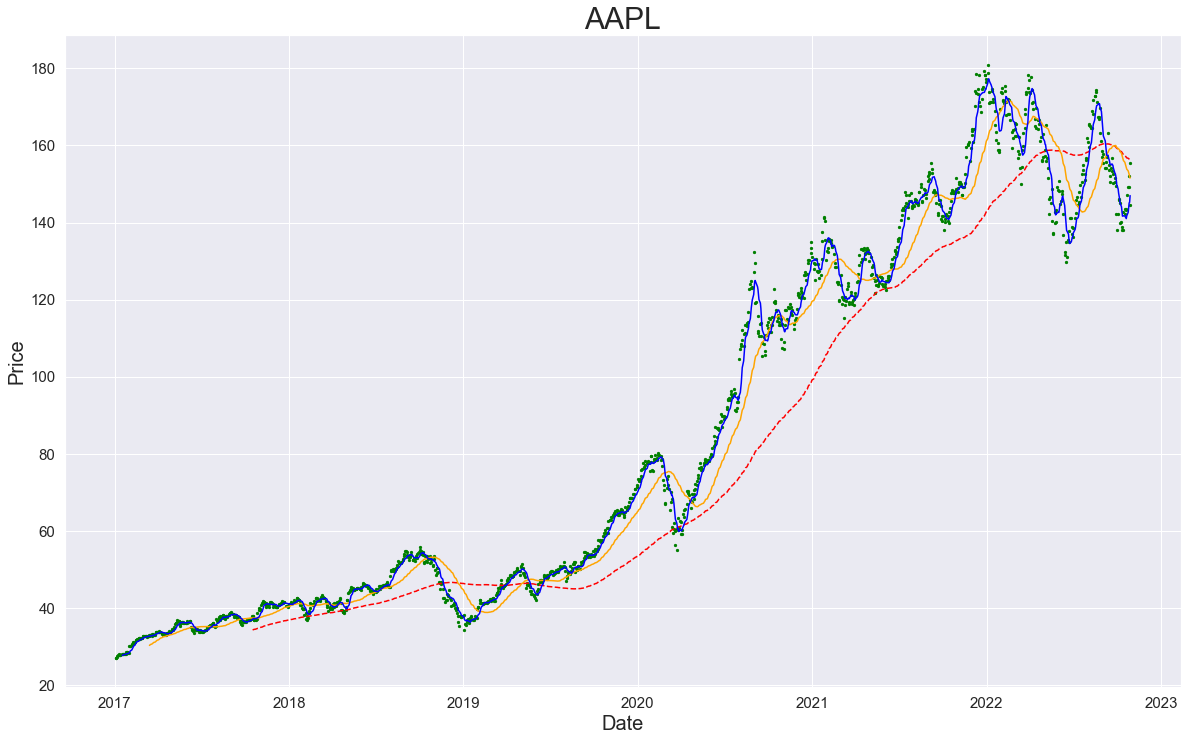

In [33]:
SMA_plot(stocks.AAPL, 200,50,10)

1467
1467
1467
1467
1467


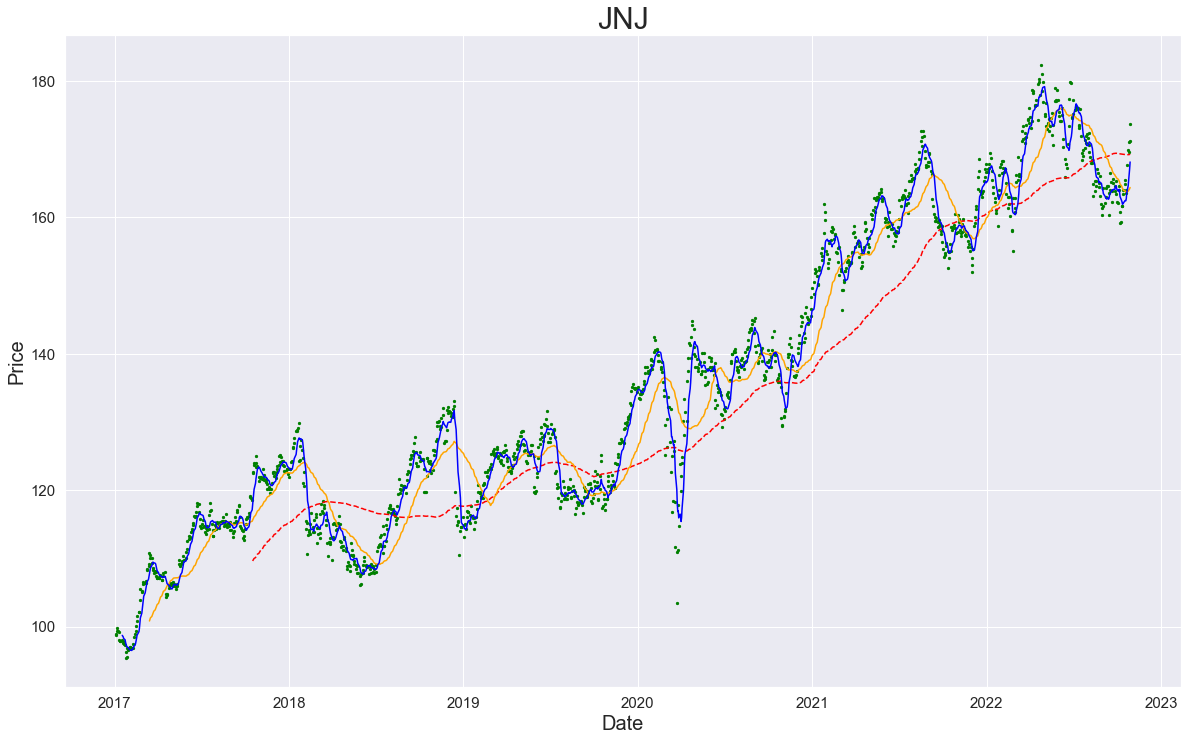

In [34]:
SMA_plot(stocks.JNJ, 200,50,10)

In [35]:
def BB_plot(df, periods, n_std):
    
    sma, upper, lower = bollinger_bands(df, periods, n_std)
    sma_list = sma.values.tolist()
    upper_list = upper.values.tolist()
    lower_list = lower.values.tolist()
    close = df.values.tolist()
    dates = df.index.values       
    plt.plot(dates, upper, color='red', linestyle='dashed')
    plt.plot(dates, lower, color='red', linestyle='dashed')
    plt.plot(dates, sma, color='blue')
    plt.scatter(dates, close, s=5, color='green')    
    plt.title(df.name, fontsize='30')
    plt.xlabel('Date', fontsize='20')
    plt.ylabel('Price', fontsize='20')


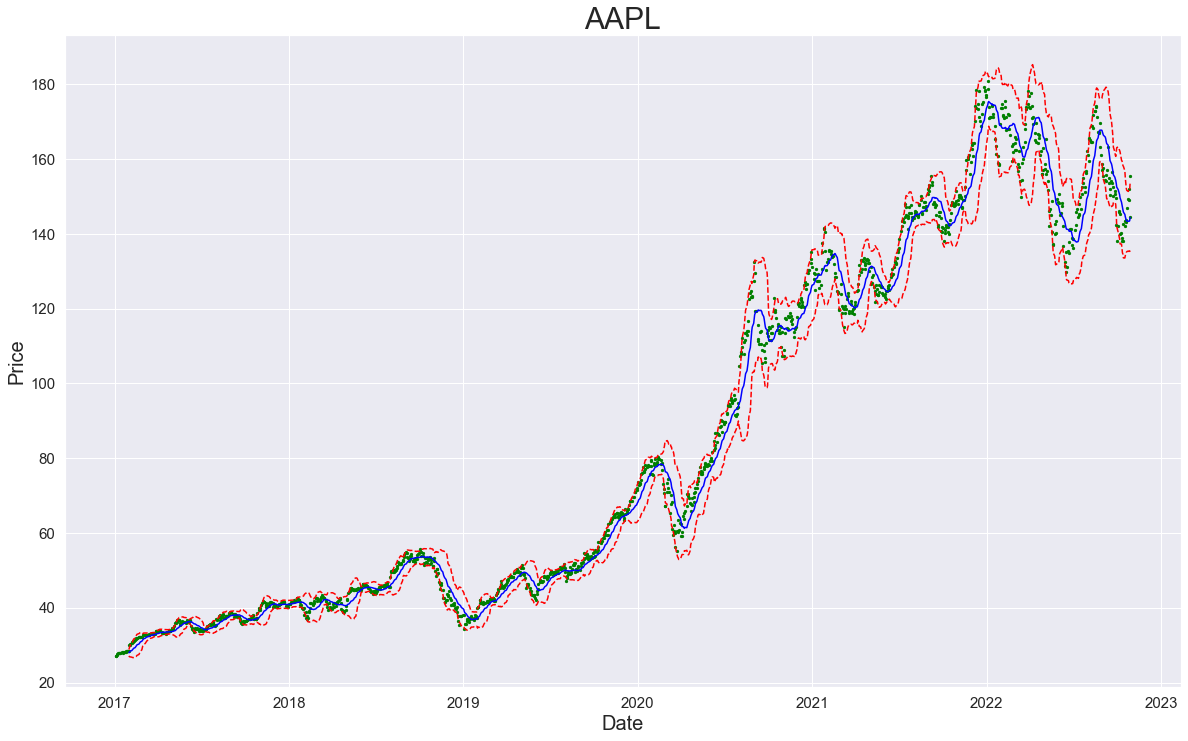

In [36]:
BB_plot(stocks.AAPL, 20, 2)

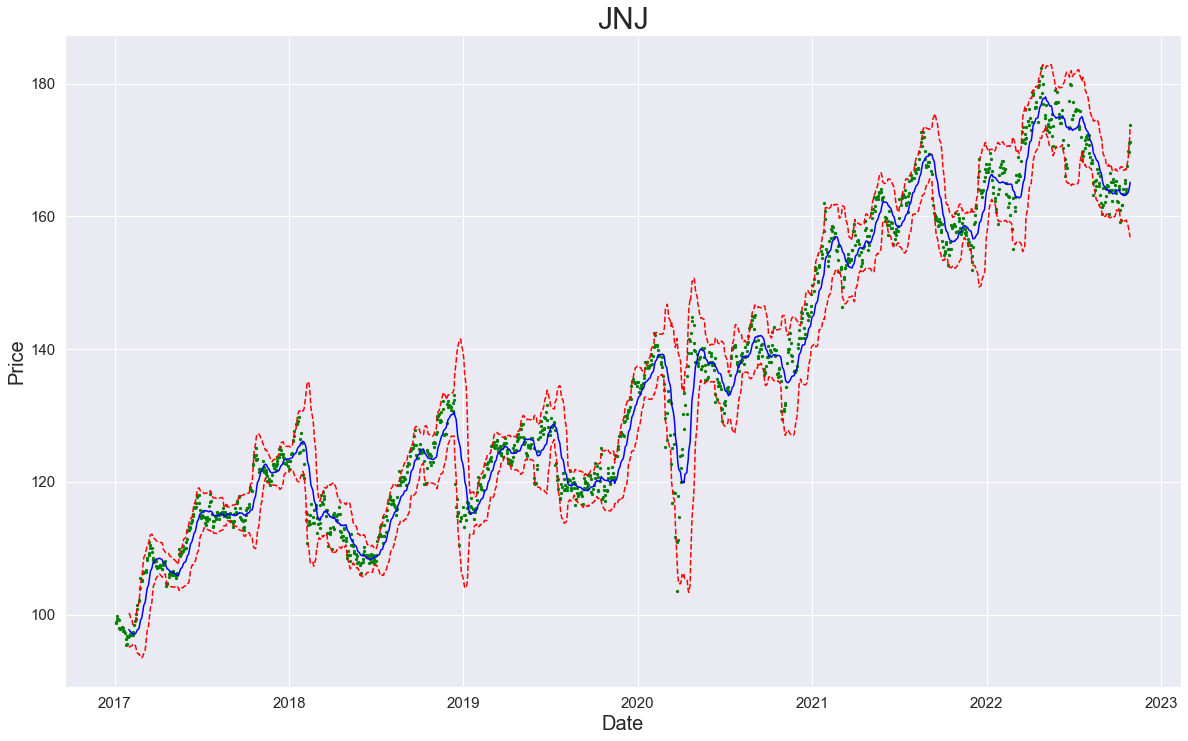

In [37]:
BB_plot(stocks.JNJ, 20, 2)

# Machine Learn

# Linear Regression

In [38]:
data = get_data(['^RUI'], '2012-03-11', '2022-07-10')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-12,759.429993,760.619995,756.840027,759.130005,759.130005,0
2012-03-13,761.450012,773.030029,761.450012,772.979980,772.979980,0
2012-03-14,773.190002,774.679993,769.280029,771.630005,771.630005,0
2012-03-15,772.380005,776.469971,770.739990,776.419983,776.419983,0
2012-03-16,776.559998,778.099976,775.640015,777.130005,777.130005,0


In [39]:
# Other Features
data['RSI'] = ta.rsi(data['Adj Close'], lenghth=15)
data['EMAF'] = ta.ema(data['Adj Close'], lenght=20)
data['EMAM'] = ta.ema(data['Adj Close'], lenght=100)
data['EMAS'] = ta.ema(data['Adj Close'], lenght=150)
data['BBupper 2'] = bollinger_bands(data['Adj Close'], 2, 2)[1]
data['BBlower 2'] = bollinger_bands(data['Adj Close'], 2, 2)[2]
#defining Predict as the next Adj Close Price
data['Predict Next Day'] = data['Adj Close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [40]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,BBupper 2,BBlower 2,Predict Next Day
0,777.419983,780.429993,775.049988,778.919983,62.815527,776.920039,776.920039,776.920039,781.397466,773.732539,783.150024
1,778.270020,786.679993,776.669983,783.150024,67.135117,778.052764,778.052764,778.052764,787.017186,775.052822,781.989990
2,784.520020,784.840027,777.140015,781.989990,64.908263,778.768623,778.768623,778.768623,784.210543,780.929471,773.719971
3,779.679993,779.679993,771.059998,773.719971,51.733706,777.850686,777.850686,777.850686,789.550554,766.159407,773.130005
4,773.469971,775.210022,770.559998,773.130005,50.939388,776.992381,776.992381,776.992381,774.259325,772.590650,764.270020


In [41]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1)) #will rescale the values between 0 and 1
data_set_scaled = sc.fit_transform(data_set)

data_set_scaled

array([[0.03751187, 0.03672186, 0.0389696 , ..., 0.03753484, 0.04310646,
        0.03981122],
       [0.03794623, 0.03990466, 0.03979841, ..., 0.04034277, 0.04377869,
        0.03921799],
       [0.04113993, 0.03896766, 0.04003889, ..., 0.03894041, 0.04677085,
        0.03498884],
       ...,
       [0.70953206, 0.71180135, 0.69323641, ..., 0.7020073 , 0.71530685,
        0.71854987],
       [0.71648658, 0.72114597, 0.71258568, ..., 0.70375493, 0.7190605 ,
        0.73588072],
       [0.72148921, 0.73333236, 0.72499231, ..., 0.73399938, 0.70791481,
        0.73454595]])

In [42]:
def train_test_split_custom(data, size):
    
    test_size = int(data.shape[0] * size)
    x_train = data[:test_size,0:-1]
    y_train = data[:test_size,-1]
    x_test = data[test_size:,0:-1]
    y_test = data[test_size:,-1]
    return x_train, x_test, y_train, y_test

In [43]:
x_train, x_test, y_train, y_test = train_test_split_custom(data_set_scaled, .8)

In [44]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [45]:
y_pred = regressor.predict(x_test)
np.set_printoptions(precision=2) # Display any numerical value with 2 decimal
compared = np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test),1)),1)
print(compared)

[[0.52 0.52]
 [0.52 0.52]
 [0.52 0.53]
 ...
 [0.71 0.72]
 [0.72 0.74]
 [0.73 0.73]]


In [46]:
# MSE
mean_squared_error(y_test, y_pred)

0.00017575422298514204

In [47]:
# RMSE
mean_squared_error(y_test, y_pred, squared=False)

0.013257232855507292

In [48]:
# R squared score (R² score)
# A high r2_score reflects a good model performance on the test set.
r2_score(y_test, y_pred)

0.9897841881616146

In [49]:
for i in range(50):
    print(y_pred[i], y_test[i], f'Predictions accuracy {round(float((y_pred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

0.5201959905469167 0.5169779189686436 Predictions accuracy 0.62% of actual value
0.5185763274797055 0.5225775420481273 Predictions accuracy -0.77% of actual value
0.5211080526139009 0.5261265751905085 Predictions accuracy -0.95% of actual value
0.5265741130458625 0.5027000724282923 Predictions accuracy 4.75% of actual value
0.5062425565240596 0.5126106848976009 Predictions accuracy -1.24% of actual value
0.5093639583519745 0.49192525200473114 Predictions accuracy 3.54% of actual value
0.49503818992611354 0.5040603697073388 Predictions accuracy -1.79% of actual value
0.5003417956882703 0.5176069105423976 Predictions accuracy -3.34% of actual value
0.5148519921963572 0.5223372068398152 Predictions accuracy -1.43% of actual value
0.5221949560005192 0.5265765950649818 Predictions accuracy -0.83% of actual value
0.52759328003279 0.5408339662940795 Predictions accuracy -2.45% of actual value
0.5384921081991885 0.5312915348789593 Predictions accuracy 1.36% of actual value
0.5340705276122688 0

<AxesSubplot:>

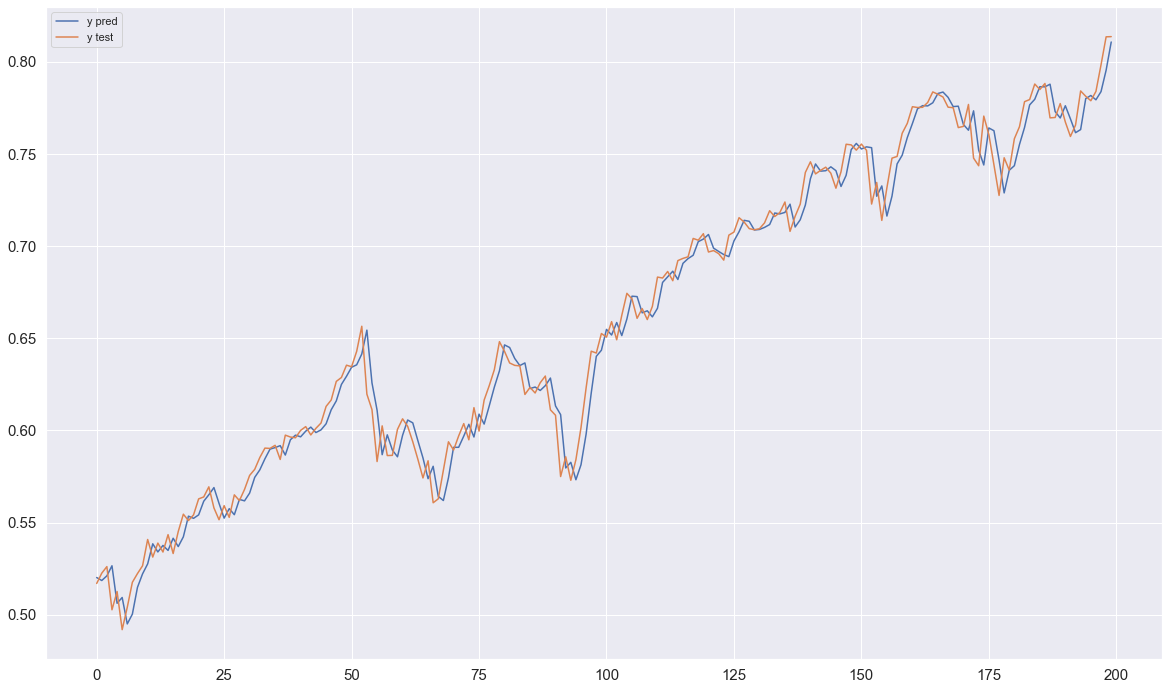

In [50]:
df = pd.DataFrame(compared, columns=['y pred', 'y test'])
df.iloc[0:200,:].plot()

# KNN

In [51]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_train, y_train)


KNeighborsRegressor(n_neighbors=2)

<AxesSubplot:>

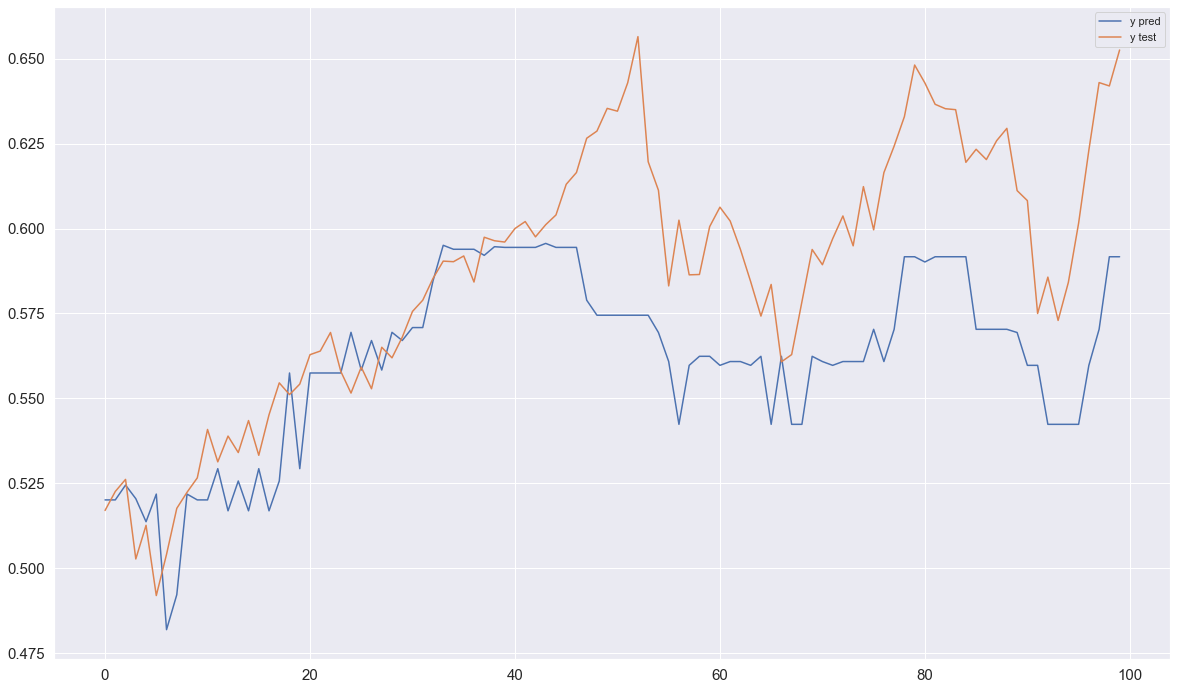

In [52]:
knn_ypred = knn.predict(x_test)
knn_compared = np.concatenate((knn_ypred.reshape(len(knn_ypred), 1), y_test.reshape(len(y_test),1)),1)
knn_df = pd.DataFrame(knn_compared, columns=['y pred', 'y test'])
knn_df.iloc[0:100,:].plot()

In [56]:
for i in range(50):
    print(y_pred[i], y_test[i], f'Predictions accuracy {round(float((y_pred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

0.5201959905469167 0.5169779189686436 Predictions accuracy 0.62% of actual value
0.5185763274797055 0.5225775420481273 Predictions accuracy -0.77% of actual value
0.5211080526139009 0.5261265751905085 Predictions accuracy -0.95% of actual value
0.5265741130458625 0.5027000724282923 Predictions accuracy 4.75% of actual value
0.5062425565240596 0.5126106848976009 Predictions accuracy -1.24% of actual value
0.5093639583519745 0.49192525200473114 Predictions accuracy 3.54% of actual value
0.49503818992611354 0.5040603697073388 Predictions accuracy -1.79% of actual value
0.5003417956882703 0.5176069105423976 Predictions accuracy -3.34% of actual value
0.5148519921963572 0.5223372068398152 Predictions accuracy -1.43% of actual value
0.5221949560005192 0.5265765950649818 Predictions accuracy -0.83% of actual value
0.52759328003279 0.5408339662940795 Predictions accuracy -2.45% of actual value
0.5384921081991885 0.5312915348789593 Predictions accuracy 1.36% of actual value
0.5340705276122688 0

# LSTM

In [57]:
X = []
n_features = len(data_set.columns)
back_days = 50
print(data_set_scaled.shape[0])
for j in range(n_features):
    X.append([])
    for i in range(back_days, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back_days:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back_days:,-1])
y=np.reshape(yi,(len(yi),1))



2583


In [58]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
X_train.shape

2026


(2026, 50, 11)

In [59]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

np.random.seed(10)

lstm_input = Input(shape=(back_days, n_features), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=50, shuffle=True, validation_split = 0.1)

Epoch 1/50
122/122 [==============================] - 5s 27ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 2/50
122/122 [==============================] - 3s 22ms/step - loss: 7.6276e-05 - val_loss: 9.6213e-04
Epoch 3/50
122/122 [==============================] - 3s 22ms/step - loss: 7.5017e-05 - val_loss: 9.4530e-04
Epoch 4/50
122/122 [==============================] - 3s 22ms/step - loss: 7.5289e-05 - val_loss: 9.6637e-04
Epoch 5/50
122/122 [==============================] - 3s 22ms/step - loss: 7.8854e-05 - val_loss: 8.9206e-04
Epoch 6/50
122/122 [==============================] - 3s 22ms/step - loss: 6.8292e-05 - val_loss: 8.7667e-04
Epoch 7/50
122/122 [==============================] - 3s 22ms/step - loss: 6.8371e-05 - val_loss: 8.3199e-04
Epoch 8/50
122/122 [==============================] - 3s 22ms/step - loss: 6.3898e-05 - val_loss: 8.8593e-04
Epoch 9/50
122/122 [==============================] - 3s 21ms/step - loss: 7.1694e-05 - val_loss: 9.4022e-04
Epoch 10/50
122/122 [======

In [60]:
from math import ceil
y_pred = model.predict(X_test)

for i in range(50):
    print(y_pred[i], y_test[i], f'Predictions accuracy {round(float((y_pred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

16/16 [==============================] - 1s 12ms/step
[0.53] [0.54] Predictions accuracy -2.51% of actual value
[0.54] [0.53] Predictions accuracy 0.92% of actual value
[0.54] [0.54] Predictions accuracy -0.27% of actual value
[0.54] [0.53] Predictions accuracy 0.88% of actual value
[0.54] [0.54] Predictions accuracy -0.89% of actual value
[0.54] [0.53] Predictions accuracy 1.57% of actual value
[0.54] [0.55] Predictions accuracy -0.86% of actual value
[0.54] [0.55] Predictions accuracy -2.01% of actual value
[0.55] [0.55] Predictions accuracy -0.08% of actual value
[0.55] [0.55] Predictions accuracy 0.11% of actual value
[0.56] [0.56] Predictions accuracy -1.3% of actual value
[0.56] [0.56] Predictions accuracy -0.54% of actual value
[0.57] [0.57] Predictions accuracy -0.73% of actual value
[0.57] [0.56] Predictions accuracy 2.13% of actual value
[0.57] [0.55] Predictions accuracy 2.8% of actual value
[0.56] [0.56] Predictions accuracy -0.07% of actual value
[0.56] [0.55] Predictions 

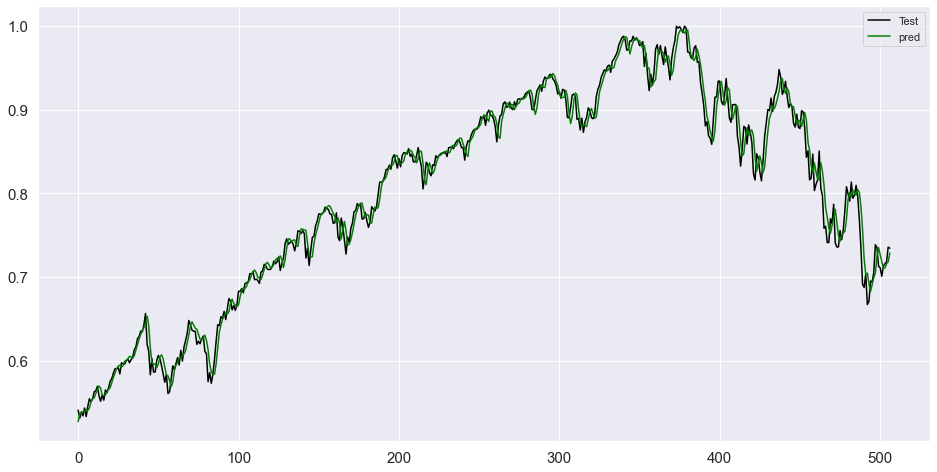

In [61]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()